In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
google_flowers = False
class_name_file = './data/class_indices.json'
train_data_path = "/media/stree/localssd/DL_data/flower_data2/train"
val_data_path = "/media/stree/localssd/DL_data/flower_data2/val"
test_data_path = "/media/stree/localssd/DL_data/flower_data2/val/"

if not google_flowers:
    class_name_file = './data/flowers_17_cat_to_name.json'
    train_data_path = "/media/stree/localssd/DL_data/flower_17/train"
    val_data_path = "/media/stree/localssd/DL_data/flower_17/val"
    test_data_path = "/media/stree/localssd/DL_data/flower_17/test/"
    
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open(class_name_file, 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes(train_data_path)
print(classes)
print(c_2_idx)
print()
cls_2_name = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    print('k: ', k, ' cls: ', cls)
    if google_flowers:
        cls_2_name[str(cls)] = cat_to_name[str(cls)]
    else:
        cls_2_name[int(cls)] = cat_to_name[str(k)]
print(cls_2_name)

{'1': 'pink primrose', '2': 'hard-leaved pocket orchid', '3': 'canterbury bells', '4': 'sweet pea', '5': 'english marigold', '6': 'tiger lily', '7': 'moon orchid', '8': 'bird of paradise', '9': 'monkshood', '10': 'globe thistle', '11': 'snapdragon', '12': "colt's foot", '13': 'king protea', '14': 'spear thistle', '15': 'yellow iris', '16': 'globe-flower', '17': 'purple coneflower'}
pink primrose
sweet pea

['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']
{'1': 0, '10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '2': 9, '3': 10, '4': 11, '5': 12, '6': 13, '7': 14, '8': 15, '9': 16}

dict_keys(['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9'])

k:  1  cls:  0
k:  10  cls:  1
k:  11  cls:  2
k:  12  cls:  3
k:  13  cls:  4
k:  14  cls:  5
k:  15  cls:  6
k:  16  cls:  7
k:  17  cls:  8
k:  2  cls:  9
k:  3  cls:  10
k:  4  cls:  11
k:  5  cls:  12
k:  6  cls:  13
k:  7  cls:  14

In [3]:

# Note transforms.ToTensor() scales input images
# to 0-1 range
data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
    
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=data_transform['train'])

val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=data_transform['val'])

batch_size=16

nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 4])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
    
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,
                                               num_workers=nw)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False,
                                              num_workers=nw)

device = torch.device("cpu")
use_gpu = False
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda:0")
    use_gpu = True
        
print(device)
print(('load data ---> done!'))

Using 4 dataloader workers every process
cuda:0
load data ---> done!


In [4]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([ 8,  8,  0,  5,  2,  5,  7,  4,  6, 10, 15,  4, 12,  0,  9, 15])


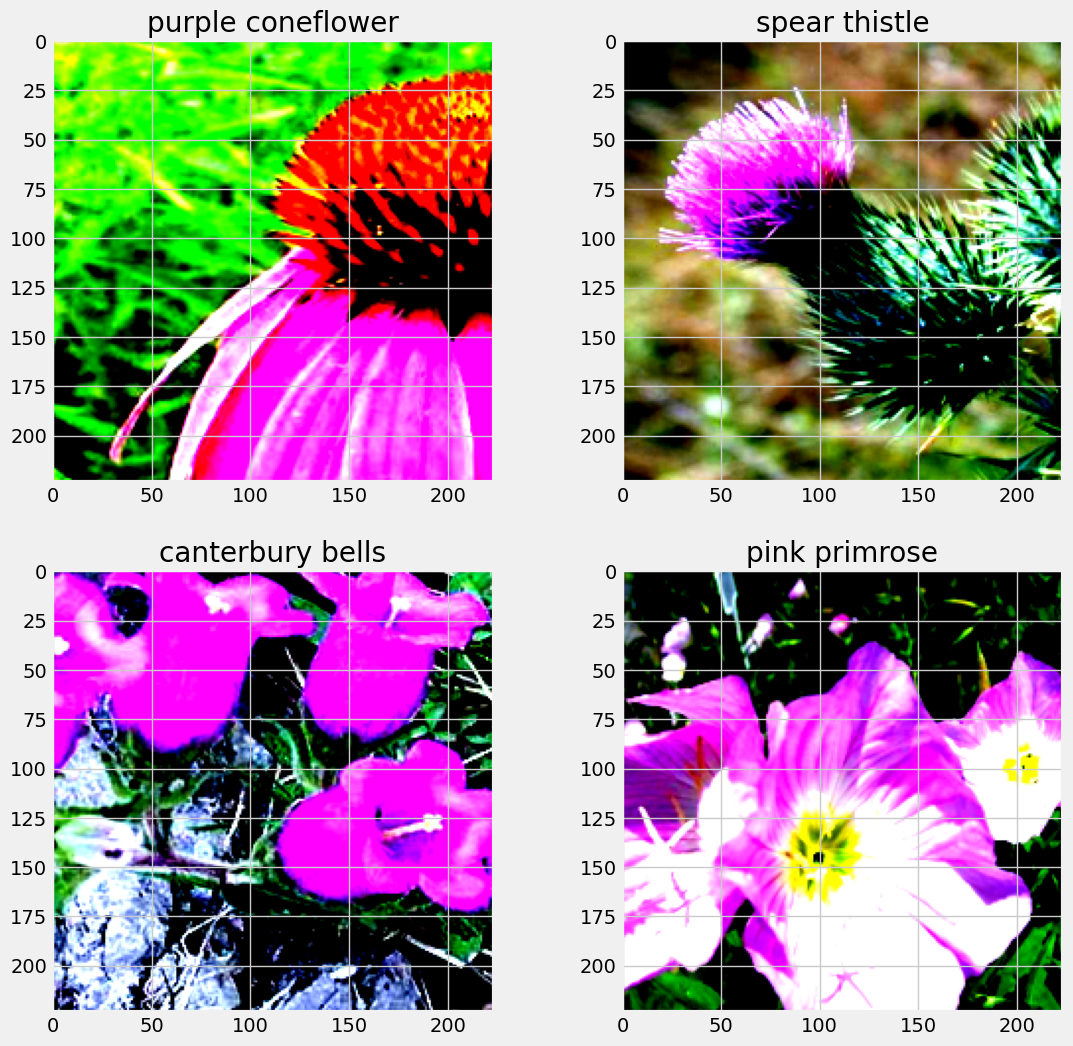

In [5]:
it = iter(train_data_loader)

dt,target = it.__next__()
print(dt[1].shape)
print(target)

# 显示图片
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
if google_flowers:
    axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
    axes[0,0].title.set_text(cls_2_name[str(target[1].numpy())])
    axes[0,1].imshow(dt[5].numpy().transpose(1, 2, 0))
    axes[0,1].title.set_text(cls_2_name[str(target[5].numpy())])
    axes[1,0].imshow(dt[9].numpy().transpose(1, 2, 0))
    axes[1,0].title.set_text(cls_2_name[str(target[9].numpy())])
    axes[1,1].imshow(dt[13].numpy().transpose(1, 2, 0))
    axes[1,1].title.set_text(cls_2_name[str(target[13].numpy())])
else:
    axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
    axes[0,0].title.set_text(cls_2_name[int(target[1].numpy())])
    axes[0,1].imshow(dt[5].numpy().transpose(1, 2, 0))
    axes[0,1].title.set_text(cls_2_name[int(target[5].numpy())])
    axes[1,0].imshow(dt[9].numpy().transpose(1, 2, 0))
    axes[1,0].title.set_text(cls_2_name[int(target[9].numpy())])
    axes[1,1].imshow(dt[13].numpy().transpose(1, 2, 0))
    axes[1,1].title.set_text(cls_2_name[int(target[13].numpy())])
plt.show()

In [6]:
################################
# network InceptionV3
################################

def ConvBNReLU(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                  stride=stride,padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6(inplace=True),
    )

def ConvBNReLUFactorization(in_channels,out_channels,kernel_sizes,paddings):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_sizes, 
                  stride=1,padding=paddings),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_sizes,
                  stride=1, padding=paddings),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6(inplace=True),
    )

class InceptionV3ModuleA(nn.Module):
    def __init__(self, in_channels,out_channels1,out_channels2reduce, out_channels2, out_channels3reduce, 
                 out_channels3, out_channels4):
        super(InceptionV3ModuleA, self).__init__()

        self.branch1 = ConvBNReLU(in_channels=in_channels,out_channels=out_channels1,kernel_size=1)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1),
            ConvBNReLU(in_channels=out_channels2reduce, out_channels=out_channels2, kernel_size=5, padding=2),
        )

        self.branch3 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels,out_channels=out_channels3reduce,kernel_size=1),
            ConvBNReLU(in_channels=out_channels3reduce, out_channels=out_channels3, kernel_size=3, padding=1),
            ConvBNReLU(in_channels=out_channels3, out_channels=out_channels3, kernel_size=3, padding=1),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels4, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

class InceptionV3ModuleB(nn.Module):
    def __init__(self, in_channels,out_channels1,out_channels2reduce, out_channels2, out_channels3reduce,
                 out_channels3, out_channels4):
        super(InceptionV3ModuleB, self).__init__()

        self.branch1 = ConvBNReLU(in_channels=in_channels,out_channels=out_channels1,kernel_size=1)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1),
            ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2reduce,
                                    kernel_sizes=[1,7],paddings=[0,3]),
            ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2, 
                                    kernel_sizes=[7,1],paddings=[3, 0]),
        )

        self.branch3 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels,out_channels=out_channels3reduce,kernel_size=1),
            ConvBNReLUFactorization(in_channels=out_channels3reduce, out_channels=out_channels3reduce,
                                    kernel_sizes=[7, 1], paddings=[3, 0]),
            ConvBNReLUFactorization(in_channels=out_channels3reduce, out_channels=out_channels3reduce,
                                    kernel_sizes=[1, 7], paddings=[0, 3]),
            ConvBNReLUFactorization(in_channels=out_channels3reduce, out_channels=out_channels3reduce,
                                    kernel_sizes=[7, 1], paddings=[3, 0]),
            ConvBNReLUFactorization(in_channels=out_channels3reduce, 
                                    out_channels=out_channels3,kernel_sizes=[1, 7], paddings=[0, 3]),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels4, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

class InceptionV3ModuleC(nn.Module):
    def __init__(self, in_channels,out_channels1,out_channels2reduce, out_channels2, out_channels3reduce, 
                 out_channels3, out_channels4):
        super(InceptionV3ModuleC, self).__init__()

        self.branch1 = ConvBNReLU(in_channels=in_channels,out_channels=out_channels1,kernel_size=1)

        self.branch2_conv1 = ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1)
        self.branch2_conv2a = ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2, 
                                                      kernel_sizes=[1,3],paddings=[0,1])
        self.branch2_conv2b = ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2,
                                                      kernel_sizes=[3,1],paddings=[1, 0])

        self.branch3_conv1 = ConvBNReLU(in_channels=in_channels,out_channels=out_channels3reduce,kernel_size=1)
        self.branch3_conv2 = ConvBNReLU(in_channels=out_channels3reduce, out_channels=out_channels3, 
                                        kernel_size=3,stride=1,padding=1)
        self.branch3_conv3a = ConvBNReLUFactorization(in_channels=out_channels3, out_channels=out_channels3,
                                                      kernel_sizes=[3, 1],paddings=[1, 0])
        self.branch3_conv3b = ConvBNReLUFactorization(in_channels=out_channels3, out_channels=out_channels3,
                                                      kernel_sizes=[1, 3],paddings=[0, 1])

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels4, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        x2 = self.branch2_conv1(x)
        out2 = torch.cat([self.branch2_conv2a(x2), self.branch2_conv2b(x2)],dim=1)
        x3 = self.branch3_conv2(self.branch3_conv1(x))
        out3 = torch.cat([self.branch3_conv3a(x3), self.branch3_conv3b(x3)], dim=1)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

class InceptionV3ModuleD(nn.Module):
    def __init__(self, in_channels,out_channels1reduce,out_channels1,out_channels2reduce, out_channels2):
        super(InceptionV3ModuleD, self).__init__()

        self.branch1 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels1reduce, kernel_size=1),
            ConvBNReLU(in_channels=out_channels1reduce, out_channels=out_channels1, kernel_size=3,stride=2)
        )

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1),
            ConvBNReLU(in_channels=out_channels2reduce, out_channels=out_channels2, kernel_size=3, stride=1,
                       padding=1),
            ConvBNReLU(in_channels=out_channels2, out_channels=out_channels2, kernel_size=3, stride=2),
        )

        self.branch3 = nn.MaxPool2d(kernel_size=3,stride=2)

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out = torch.cat([out1, out2, out3], dim=1)
        return out


class InceptionV3ModuleE(nn.Module):
    def __init__(self, in_channels, out_channels1reduce,out_channels1, out_channels2reduce, out_channels2):
        super(InceptionV3ModuleE, self).__init__()

        self.branch1 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels1reduce, kernel_size=1),
            ConvBNReLU(in_channels=out_channels1reduce, out_channels=out_channels1, kernel_size=3, stride=2),
        )

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1),
            ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2reduce,
                                    kernel_sizes=[1, 7], paddings=[0, 3]),
            ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2reduce,
                                    kernel_sizes=[7, 1], paddings=[3, 0]),
            ConvBNReLU(in_channels=out_channels2reduce, out_channels=out_channels2, kernel_size=3, stride=2),
        )

        self.branch3 = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out = torch.cat([out1, out2, out3], dim=1)
        return out

class InceptionAux(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(InceptionAux, self).__init__()

        self.auxiliary_avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.auxiliary_conv1 = ConvBNReLU(in_channels=in_channels, out_channels=128, kernel_size=1)
        self.auxiliary_conv2 = nn.Conv2d(in_channels=128, out_channels=768, kernel_size=5,stride=1)
        self.auxiliary_dropout = nn.Dropout(p=0.7)
        self.auxiliary_linear1 = nn.Linear(in_features=768, out_features=out_channels)

    def forward(self, x):
        x = self.auxiliary_conv1(self.auxiliary_avgpool(x))
        x = self.auxiliary_conv2(x)
        x = x.view(x.size(0), -1)
        out = self.auxiliary_linear1(self.auxiliary_dropout(x))
        return out

class InceptionV3(nn.Module):
    def __init__(self, num_classes=1000, stage='train'):
        super(InceptionV3, self).__init__()
        self.stage = stage

        self.block1 = nn.Sequential(
            ConvBNReLU(in_channels=3, out_channels=32, kernel_size=3, stride=2),
            ConvBNReLU(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            ConvBNReLU(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.block2 = nn.Sequential(
            ConvBNReLU(in_channels=64, out_channels=80, kernel_size=3, stride=1),
            ConvBNReLU(in_channels=80, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.block3 = nn.Sequential(
            InceptionV3ModuleA(in_channels=192, out_channels1=64,out_channels2reduce=48, out_channels2=64, 
                               out_channels3reduce=64, out_channels3=96, out_channels4=32),
            InceptionV3ModuleA(in_channels=256, out_channels1=64,out_channels2reduce=48, out_channels2=64, 
                               out_channels3reduce=64, out_channels3=96, out_channels4=64),
            InceptionV3ModuleA(in_channels=288, out_channels1=64,out_channels2reduce=48, out_channels2=64, 
                               out_channels3reduce=64, out_channels3=96, out_channels4=64)
        )

        self.block4 = nn.Sequential(
            InceptionV3ModuleD(in_channels=288, out_channels1reduce=384,out_channels1=384,out_channels2reduce=64,
                               out_channels2=96),
            InceptionV3ModuleB(in_channels=768, out_channels1=192, out_channels2reduce=128,  out_channels2=192,
                               out_channels3reduce=128,out_channels3=192, out_channels4=192),
            InceptionV3ModuleB(in_channels=768, out_channels1=192, out_channels2reduce=160,  out_channels2=192,
                               out_channels3reduce=160, out_channels3=192, out_channels4=192),
            InceptionV3ModuleB(in_channels=768, out_channels1=192, out_channels2reduce=160, out_channels2=192,
                               out_channels3reduce=160, out_channels3=192, out_channels4=192),
            InceptionV3ModuleB(in_channels=768, out_channels1=192, out_channels2reduce=192, out_channels2=192,
                               out_channels3reduce=192, out_channels3=192, out_channels4=192),
        )
        if self.stage=='train':
            self.aux_logits = InceptionAux(in_channels=768,out_channels=num_classes)

        self.block5 = nn.Sequential(
            InceptionV3ModuleE(in_channels=768, out_channels1reduce=192,out_channels1=320, out_channels2reduce=192,
                               out_channels2=192),
            InceptionV3ModuleC(in_channels=1280, out_channels1=320, out_channels2reduce=384,  out_channels2=384,
                               out_channels3reduce=448,out_channels3=384, out_channels4=192),
            InceptionV3ModuleC(in_channels=2048, out_channels1=320, out_channels2reduce=384, out_channels2=384,
                               out_channels3reduce=448, out_channels3=384, out_channels4=192),
        )

        self.max_pool = nn.MaxPool2d(kernel_size=8,stride=1)
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.Linear(288*18*18, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
#        aux = x = self.block4(x)
#        x = self.block5(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0),-1)
        out = self.linear(x)
        
        if self.stage == 'train':
            aux = self.aux_logits(aux)
            return aux,out
        else:
            return out

model = InceptionV3(num_classes=num_classes, stage='tt')
#print(model)
input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 17])


In [7]:
model = InceptionV3(num_classes=num_classes, stage='tt')
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 17])


In [8]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):

    for epoch in range(epochs):
        if use_gpu:
            #print(torch.cuda.memory_summary())
            torch.cuda.empty_cache()
            
        # print('---- Training ----')
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        # print('---- Validating ----')
        model.eval()
        num_correct = 0 
        num_examples = 0
        with torch.no_grad(): 
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                output = model(inputs)
                targets = targets.to(device)
                loss = loss_fn(output,targets) 
                valid_loss += loss.data.item() * inputs.size(0)
                correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
            valid_loss /= len(val_loader.dataset)

        print('Epoch: {:3d},  Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [9]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001)

### Training model

In [10]:
# Training model

train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=50, device=device)

Epoch:   1,  Training Loss: 92.8983, Validation Loss: 37.2206, accuracy = 0.07
Epoch:   2,  Training Loss: 34.4904, Validation Loss: 41.2996, accuracy = 0.09
Epoch:   3,  Training Loss: 19.7421, Validation Loss: 12.3265, accuracy = 0.21
Epoch:   4,  Training Loss: 13.7024, Validation Loss: 16.8820, accuracy = 0.14
Epoch:   5,  Training Loss: 9.6222, Validation Loss: 6.5513, accuracy = 0.22
Epoch:   6,  Training Loss: 10.1783, Validation Loss: 12.7876, accuracy = 0.16
Epoch:   7,  Training Loss: 9.1681, Validation Loss: 11.8028, accuracy = 0.11
Epoch:   8,  Training Loss: 7.7836, Validation Loss: 8.8723, accuracy = 0.15
Epoch:   9,  Training Loss: 7.3729, Validation Loss: 5.1108, accuracy = 0.25
Epoch:  10,  Training Loss: 6.1597, Validation Loss: 6.8874, accuracy = 0.21
Epoch:  11,  Training Loss: 6.9471, Validation Loss: 7.1217, accuracy = 0.29
Epoch:  12,  Training Loss: 5.8904, Validation Loss: 5.4051, accuracy = 0.29
Epoch:  13,  Training Loss: 5.1366, Validation Loss: 6.4053, accu

### Test

In [11]:
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=data_transform['val'])

batch_size=16
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=nw)

loss_fn = torch.nn.CrossEntropyLoss()

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        loss = loss_fn(output,targets) 
        test_loss += loss.data.item() * inputs.size(0)
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    test_loss /= len(test_loader.dataset)

print('Test Loss: {:.4f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 1.5819, accuracy = 0.60


tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([ 0,  0,  0,  0, 10,  1,  1,  1,  1,  1, 10,  1,  1,  1,  1,  1],
       device='cuda:0')
(3, 224, 224)
(3, 1, 1)


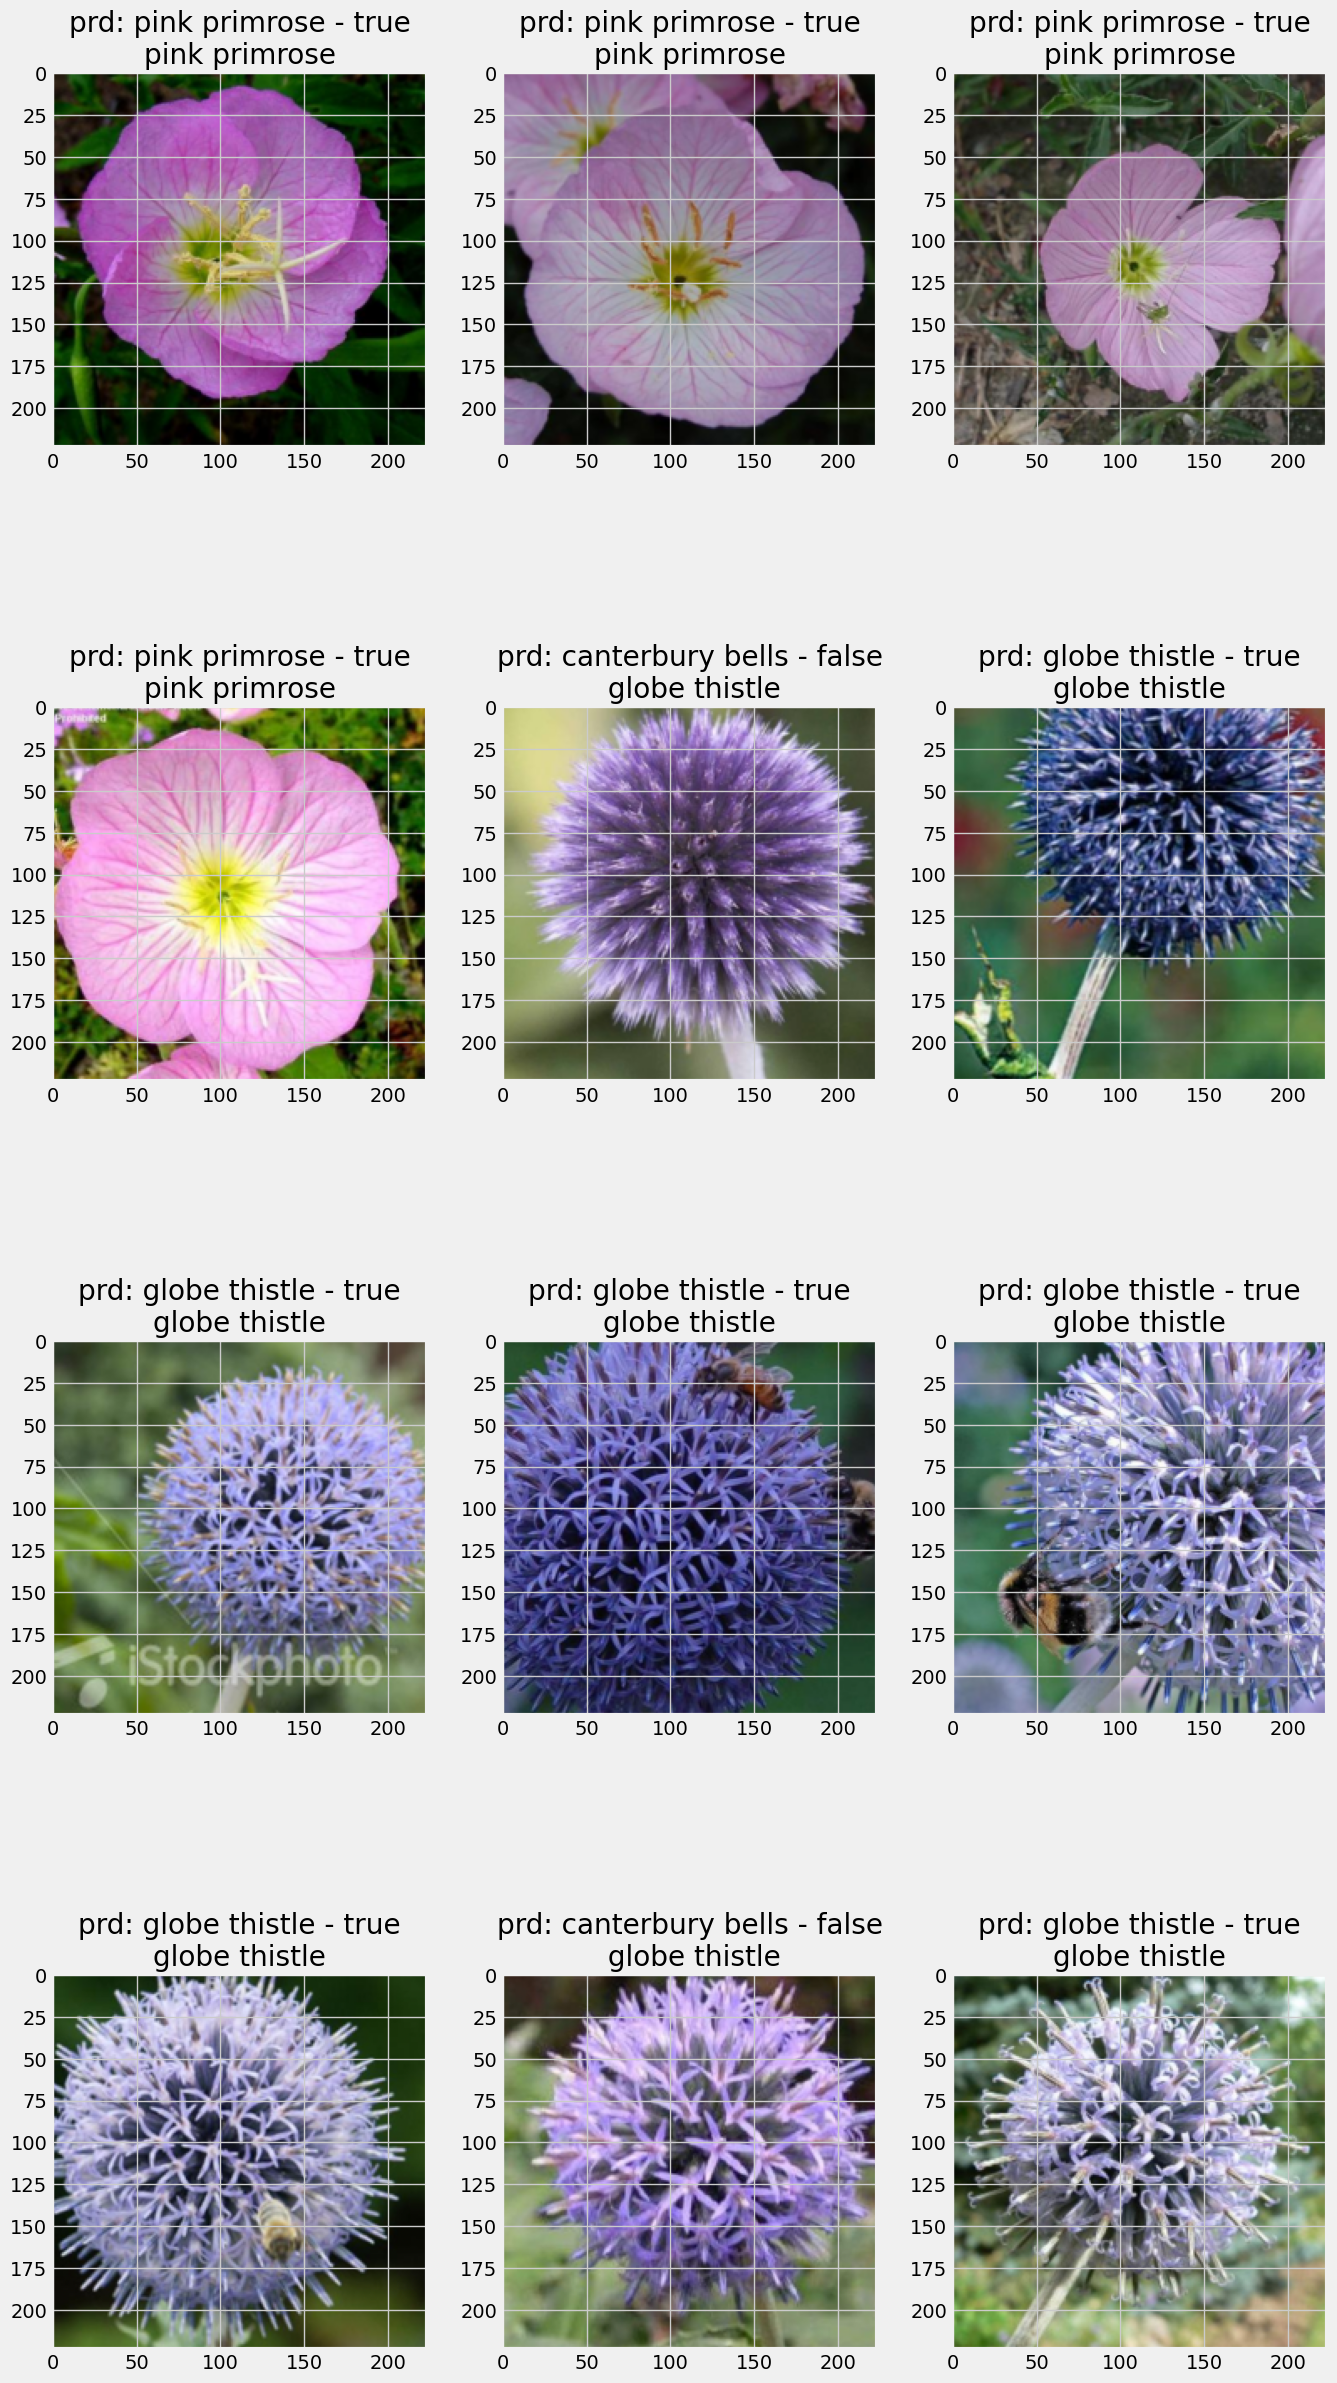

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     915 MB |    1034 MB |    3399 GB |    3398 GB |
|       from large pool |     847 MB |     965 MB |    3382 GB |    3381 GB |
|       from small pool |      68 MB |      72 MB |      16 GB |      16 GB |
|---------------------------------------------------------------------------|
| Active memory         |     915 MB |    1034 MB |    3399 GB |    3398 GB |
|       from large pool |     847 MB |     965 MB |    3382 GB |

In [12]:
it = iter(test_loader)
it.__next__()
dt, labs = it.__next__()
dt = dt.to(device)
output = model(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

img_mean = torch.tensor([0.485, 0.456, 0.406]).reshape((3, 1, 1)).to(device)
img_std = torch.tensor([0.229, 0.224, 0.225]).reshape((3, 1, 1)).to(device)
print(dt[0].cpu().numpy().shape)
print(img_mean.cpu().numpy().shape)

plt.figure(figsize=(25,30))
row = 4
col = 3
if google_flowers:
    row = 3
    col = 4
    plt.figure(figsize=(16,15))
    
k = 0
for i in range(row):
    for j in range(col):
        if google_flowers:
            ax = plt.subplot2grid((3,4), (i,j))
        else:
            ax = plt.subplot2grid((4,5), (i,j)) 
        
        # -----------------------------------------------------------------------------------------------------------------
        # tensor denormalization
        # -----------------------------------------------------------------------------------------------------------------
        img_dt = torch.mul(dt[k], img_std) + img_mean
        img_dt = img_dt*255
        img_dt = img_dt.to(torch.uint8)
        
        if use_gpu:
            img_dt = img_dt.cpu().numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - false\n ' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        else:
            img_dt = img_dt.numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - true\n ' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()

if use_gpu:
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary())